In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**DATASET LOADING AND ORGANIZATION**

Set the base project directory

In [3]:
BASE_DIR = '/content/drive/MyDrive/Chest_Xray_Disease_Classification'
print("Project Base Directory:", BASE_DIR)

Project Base Directory: /content/drive/MyDrive/Chest_Xray_Disease_Classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load and Verify Datasets Structures

In [ ]:
import os

DATASETS_PATH = os.path.join(BASE_DIR, 'datasets')
dataset_names = os.listdir(DATASETS_PATH)
print(f"Found datasets: {dataset_names}\n")

for dataset_name in dataset_names:
    dataset_path = os.path.join(DATASETS_PATH, dataset_name)
    print(f"\n🗂 Dataset: {dataset_name}")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:5]:  # just show first 5 files
            print(f"{subindent}{f}")


Found datasets: ['Chest-X-Ray-Pneumonia', 'Tuberculosis-Chest-X-ray']


🗂 Dataset: Chest-X-Ray-Pneumonia
Chest-X-Ray-Pneumonia/
  chest_xray/
    val/
      PNEUMONIA/
        person1951_bacteria_4882.jpeg
        person1950_bacteria_4881.jpeg
        person1946_bacteria_4874.jpeg
        person1949_bacteria_4880.jpeg
        person1947_bacteria_4876.jpeg
      NORMAL/
        NORMAL2-IM-1437-0001.jpeg
        NORMAL2-IM-1427-0001.jpeg
        NORMAL2-IM-1431-0001.jpeg
        NORMAL2-IM-1442-0001.jpeg
        NORMAL2-IM-1440-0001.jpeg
    __MACOSX/
      chest_xray/
        val/
          PNEUMONIA/
          NORMAL/
        test/
          PNEUMONIA/
          NORMAL/
        train/
          PNEUMONIA/
          NORMAL/
    chest_xray/
      test/
        NORMAL/
          IM-0035-0001.jpeg
          IM-0001-0001.jpeg
          IM-0017-0001.jpeg
          IM-0028-0001.jpeg
          IM-0025-0001.jpeg
        PNEUMONIA/
          person101_bacteria_483.jpeg
          person101_bacter

Dataset Cleanup — Remove Junk/System Files

In [ ]:
import os

# Remove .DS_Store and ._ files from datasets
def clean_junk_files(base_path):
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.startswith('._') or file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Clean both datasets
clean_junk_files(os.path.join(BASE_DIR, "datasets/Chest-X-Ray-Pneumonia"))
clean_junk_files(os.path.join(BASE_DIR, "datasets/Tuberculosis-Chest-X-ray"))


 **Verify Image Format & Corruption**


In [ ]:
import os
from PIL import Image
from pathlib import Path

# Directories to scan
image_dirs = [
    os.path.join(BASE_DIR, 'Chest-X-Ray-Pneumonia'),
    os.path.join(BASE_DIR, 'Tuberculosis-Chest-X-ray')
]

# Supported extensions
valid_extensions = ['.jpg', '.jpeg', '.png']

corrupted_files = []

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Will raise an exception if the image is corrupted
        return True
    except Exception:
        return False

# Scan all image files
for image_dir in image_dirs:
    for root, _, files in os.walk(image_dir):
        for filename in files:
            ext = Path(filename).suffix.lower()
            if ext in valid_extensions and not filename.startswith("._"):
                full_path = os.path.join(root, filename)
                if not is_valid_image(full_path):
                    corrupted_files.append(full_path)

# Summary
if corrupted_files:
    print(f"❌ Found {len(corrupted_files)} corrupted images:")
    for f in corrupted_files[:10]:  # show a few examples
        print("  -", f)
else:
    print("✅ All images are valid and readable.")


✅ All images are valid and readable.


**Resize and Normalize Images**

In [ ]:
import torchvision.transforms as transforms

# Resize target (compatible with VGG16, InceptionV3, EfficientNetB0, etc.)
IMG_SIZE = 224

# Define basic transformation pipeline (resize + normalize)
transform_basic = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])


**Data Augmentation (Training Only)**

In [ ]:
transform_augmented = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


**Data Splitting**

In [ ]:
import os, shutil, random, glob
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)

# Base paths
BASE_DIR = '/content/drive/MyDrive/Chest_Xray_Disease_Classification'
PNEUMONIA_DIR = os.path.join(BASE_DIR, 'datasets/Chest-X-Ray-Pneumonia/chest_xray')
TB_DIR = os.path.join(BASE_DIR, 'datasets/Tuberculosis-Chest-X-ray/TB_Chest_Radiography_Database')

# Final dataset destination
FINAL_DATASET_DIR = os.path.join(BASE_DIR, 'final_dataset')
CLASSES = ['NORMAL_PNEUMONIA', 'NORMAL_TB', 'PNEUMONIA', 'TUBERCULOSIS']

# Utility: copy and rename
def copy_images(image_paths, target_dir, label):
    os.makedirs(target_dir, exist_ok=True)
    for src in image_paths:
        fname = os.path.basename(src)
        dst = os.path.join(target_dir, f"{label}_{fname}")
        shutil.copy(src, dst)

# Rebuild dataset
def build_dataset(split_ratios=(0.7, 0.15, 0.15)):
    if os.path.exists(FINAL_DATASET_DIR):
        shutil.rmtree(FINAL_DATASET_DIR)

    # 1. Collect image paths
    pneumonia_paths = glob.glob(os.path.join(PNEUMONIA_DIR, 'train/PNEUMONIA/*.*'))
    normal_pneu_paths = glob.glob(os.path.join(PNEUMONIA_DIR, 'train/NORMAL/*.*'))
    tb_paths = glob.glob(os.path.join(TB_DIR, 'Tuberculosis/*.*'))
    normal_tb_paths = glob.glob(os.path.join(TB_DIR, 'Normal/*.*'))

    print(f"[DEBUG] PNEUMONIA images: {len(pneumonia_paths)}")
    print(f"[DEBUG] TB images: {len(tb_paths)}")
    print(f"[DEBUG] NORMAL_PNEUMONIA images: {len(normal_pneu_paths)}")
    print(f"[DEBUG] NORMAL_TB images: {len(normal_tb_paths)}")

    data = {
        'PNEUMONIA': pneumonia_paths,
        'TUBERCULOSIS': tb_paths,
        'NORMAL_PNEUMONIA': normal_pneu_paths,
        'NORMAL_TB': normal_tb_paths
    }

    # 2. Shuffle and split
    for label, paths in data.items():
        random.shuffle(paths)
        total = len(paths)
        train_end = int(split_ratios[0] * total)
        val_end = train_end + int(split_ratios[1] * total)

        copy_images(paths[:train_end], os.path.join(FINAL_DATASET_DIR, 'train', label), label)
        copy_images(paths[train_end:val_end], os.path.join(FINAL_DATASET_DIR, 'val', label), label)
        copy_images(paths[val_end:], os.path.join(FINAL_DATASET_DIR, 'test', label), label)

    print("✅ Dataset structured at:", FINAL_DATASET_DIR)

# Run it
build_dataset()


[DEBUG] PNEUMONIA images: 3897
[DEBUG] TB images: 700
[DEBUG] NORMAL_PNEUMONIA images: 1353
[DEBUG] NORMAL_TB images: 3500
✅ Dataset structured at: /content/drive/MyDrive/Chest_Xray_Disease_Classification/final_dataset


**EXPLORATORY DATA ANALYSIS**

**Dataset Structure Verification**

Objective: Confirm the correct number of samples per class and split (train, val, test).

In [ ]:
import os

splits = ['train', 'val', 'test']
classes = ['NORMAL_PNEUMONIA', 'NORMAL_TB', 'PNEUMONIA', 'TUBERCULOSIS']
FINAL_DATASET_DIR = '/content/drive/MyDrive/Chest_Xray_Disease_Classification/final_dataset'

# Structure
for split in splits:
    print(f"\n🔹 {split.upper()} Directory")
    for cls in classes:
        cls_dir = os.path.join(FINAL_DATASET_DIR, split, cls)
        if os.path.exists(cls_dir):
            print(f"{split}/{cls}: {len(os.listdir(cls_dir))} images")
        else:
            print(f"{split}/{cls}: ❌ Directory not found")



🔹 TRAIN Directory
train/NORMAL_PNEUMONIA: 947 images
train/NORMAL_TB: 2450 images
train/PNEUMONIA: 2727 images
train/TUBERCULOSIS: 489 images

🔹 VAL Directory
val/NORMAL_PNEUMONIA: 202 images
val/NORMAL_TB: 525 images
val/PNEUMONIA: 584 images
val/TUBERCULOSIS: 105 images

🔹 TEST Directory
test/NORMAL_PNEUMONIA: 204 images
test/NORMAL_TB: 525 images
test/PNEUMONIA: 586 images
test/TUBERCULOSIS: 106 images


**Class Distribution Plot**

Objective: Visualize how balanced or imbalanced the dataset is.

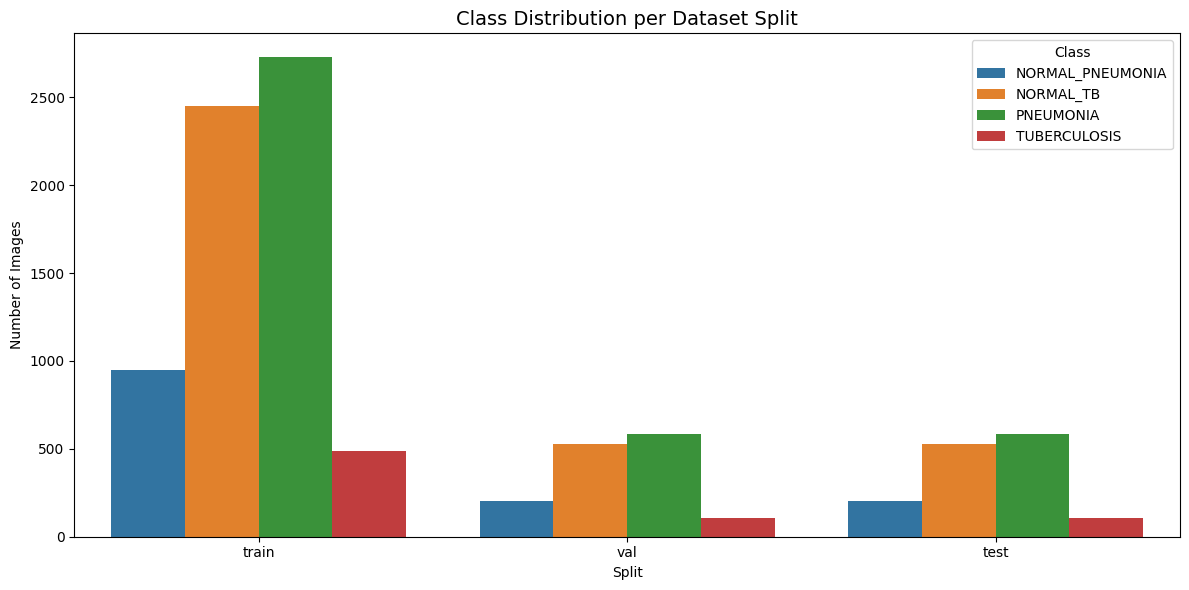

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distribution = {split: {cls: 0 for cls in classes} for split in splits}
for split in splits:
    for cls in classes:
        cls_path = os.path.join(FINAL_DATASET_DIR, split, cls)
        if os.path.exists(cls_path):
            distribution[split][cls] = len(os.listdir(cls_path))

# Convert to DataFrame
records = []
for split, cls_dict in distribution.items():
    for cls, count in cls_dict.items():
        records.append({'Split': split, 'Class': cls, 'Count': count})

df = pd.DataFrame(records)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Split', y='Count', hue='Class', data=df)
plt.title("Class Distribution per Dataset Split", fontsize=14)
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Sample Image Grid per Class**

Objective: Visually inspect a few images from each class to detect noise, artifacts, or labeling errors.

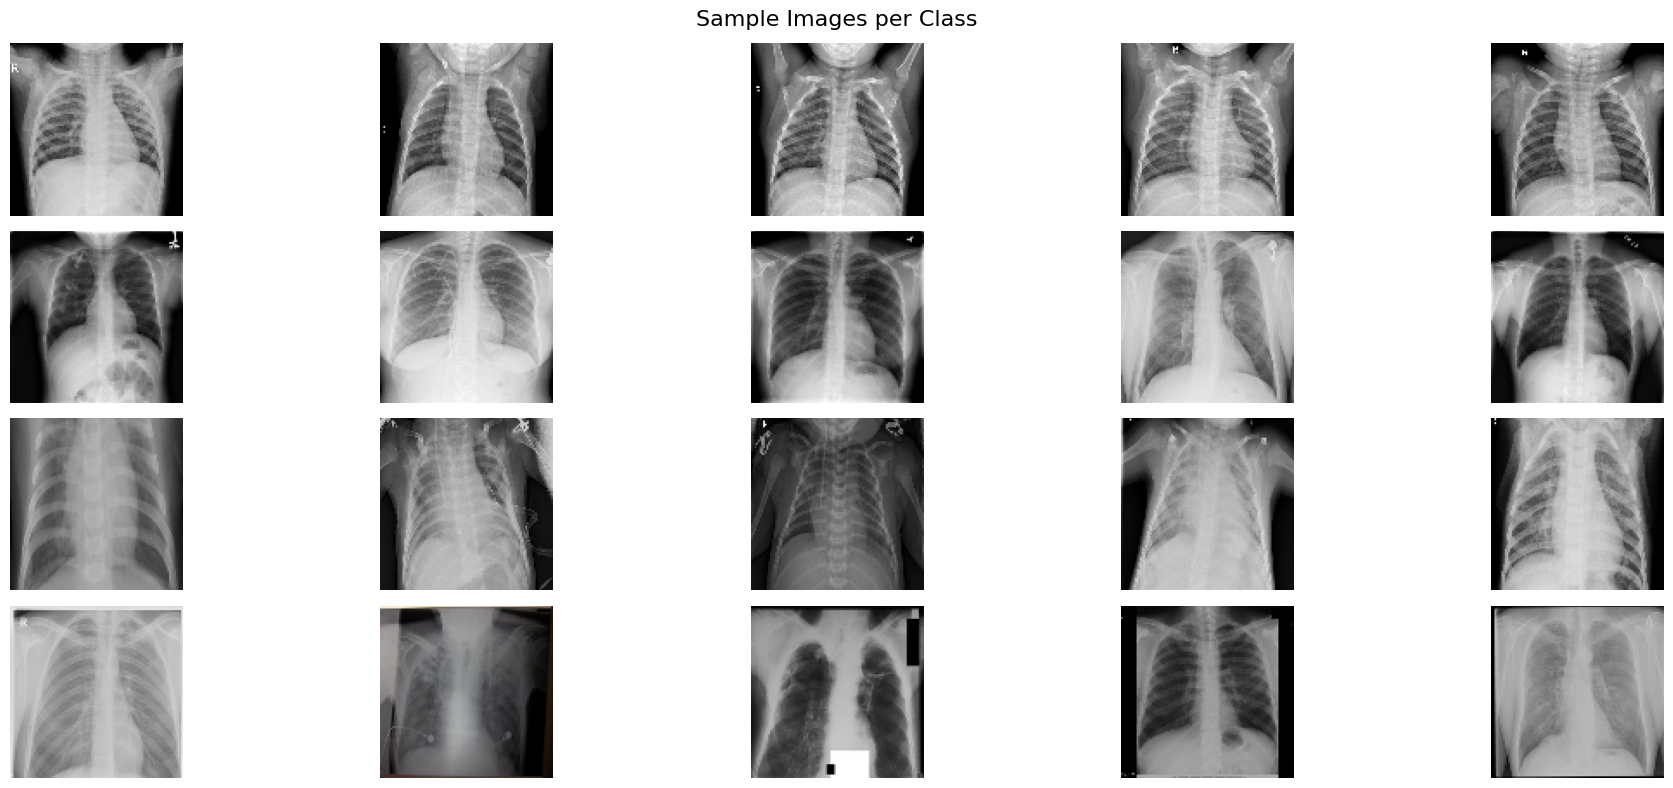

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def show_samples(dataset_path, class_names, samples_per_class=5, image_size=(100, 100)):
    plt.figure(figsize=(20, len(class_names) * 2))
    for idx, cls in enumerate(class_names):
        cls_dir = os.path.join(dataset_path, 'train', cls)
        imgs = os.listdir(cls_dir)
        for i in range(samples_per_class):
            img_path = os.path.join(cls_dir, random.choice(imgs))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            plt.subplot(len(class_names), samples_per_class, idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.ylabel(cls, fontsize=12)
    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(FINAL_DATASET_DIR, classes)


**Image Dimension Analysis**

Objective: Check if images are grayscale vs RGB and if normalization is needed.

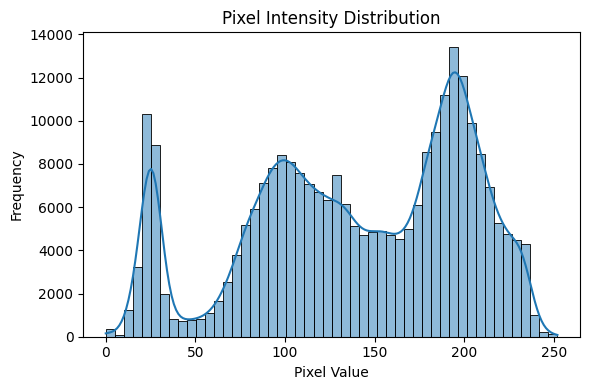

In [ ]:
def plot_intensity_distribution(sample_path):
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(6, 4))
    sns.histplot(img.ravel(), bins=50, kde=True)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Pick one random sample image
sample_image = os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_TB', random.choice(os.listdir(os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_TB'))))
plot_intensity_distribution(sample_image)


**Correlation**

 Objective: Visualize if NORMAL_TB and NORMAL_PNEUMONIA are visually similar — helps inform modeling strategy.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compare_images(img1_path, img2_path):
    img1 = cv2.resize(cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE), (224, 224))
    img2 = cv2.resize(cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE), (224, 224))
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    return mse

img1_path = os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_TB', random.choice(os.listdir(os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_TB'))))
img2_path = os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_PNEUMONIA', random.choice(os.listdir(os.path.join(FINAL_DATASET_DIR, 'train', 'NORMAL_PNEUMONIA'))))

mse_val = compare_images(img1_path, img2_path)
print(f"🔍 MSE between a NORMAL_TB and NORMAL_PNEUMONIA sample: {mse_val:.2f}")


🔍 MSE between a NORMAL_TB and NORMAL_PNEUMONIA sample: 3486.31


**Class Imbalance Detection**

Objective: Help plan balancing (oversampling, augmentation, class weights).

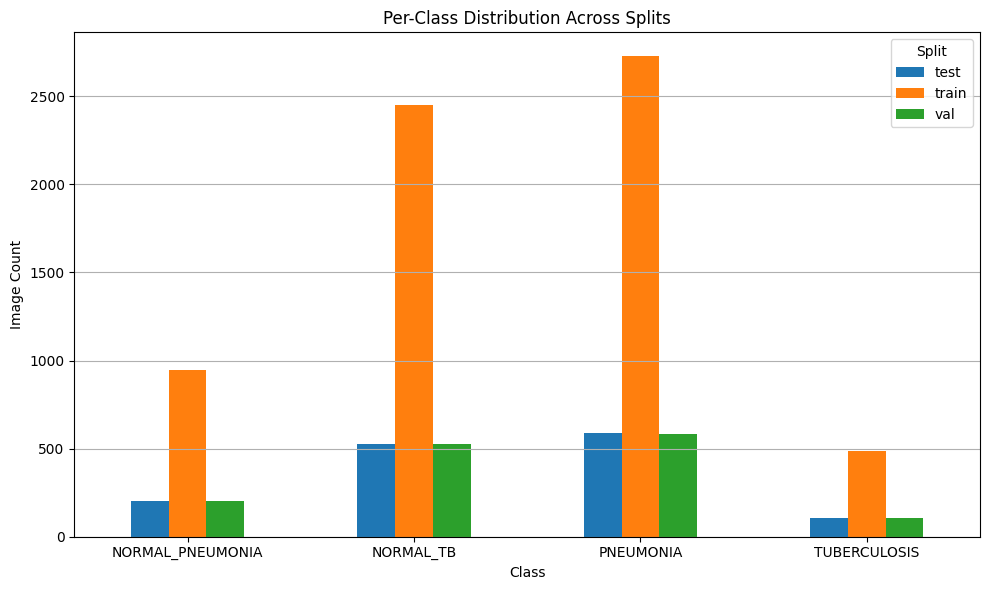

In [ ]:
# Quick imbalance check
df.pivot(index='Class', columns='Split', values='Count').plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Per-Class Distribution Across Splits")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**DATA PREPROCESSING AND AUGMENTATION SETUP**

Define Global Parameters

In [4]:
FINAL_DATASET_DIR = '/content/drive/MyDrive/Chest_Xray_Disease_Classification/final_dataset'  # Example path
DATA_DIR = FINAL_DATASET_DIR


# Image size expected by VGG16, InceptionV3, EfficientNetB0
IMG_SIZE = (224, 224)

# Batch size to feed into the model
batch_size = 32

# Dataset path
DATA_DIR = FINAL_DATASET_DIR  # Already defined in previous steps


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(FINAL_DATASET_DIR, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(FINAL_DATASET_DIR, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 6613 images belonging to 4 classes.
Found 1416 images belonging to 4 classes.


**BUILD THE HYBRID CNN MODEL**

**🎯 Goal:**

**Create a hybrid model that combines VGG16, EfficientNetB0, InceptionV3, and a custom CNN, then merge their outputs and pass them to a common classification head.**

**Define the Base Feature Extractors**

Objective: Load pre-trained CNNs without their top layers, freeze them to retain learned features, and standardize their outputs.

In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

input_shape = (*IMG_SIZE, 3)
input_layer = Input(shape=input_shape)

# VGG16 base
vgg_base = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)
vgg_base.trainable = False
vgg_out = GlobalAveragePooling2D()(vgg_base.output)

# EfficientNetB0 base
eff_base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_layer)
eff_base.trainable = False
eff_out = GlobalAveragePooling2D()(eff_base.output)

# InceptionV3 base
inc_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
inc_base.trainable = False
inc_out = GlobalAveragePooling2D()(inc_base.output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Define a Custom CNN Branch**

Objective: Build a lightweight CNN block to complement the pre-trained models

In [ ]:
# Custom CNN on the same input
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
custom_out = x


**Concatenate Features and Add Classification Head**

Objective: Merge outputs from all four branches and add dense layers for final classification.

In [ ]:
# Merge all feature vectors
merged = concatenate([vgg_out, eff_out, inc_out, custom_out])

# Fully connected layers
x = Dense(512, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer - 4 classes
output_layer = Dense(4, activation='softmax')(x)

# Final model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)
hybrid_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 42,758,599 (163.11 MB)

 Trainable params: 2,191,556 (8.36 MB)

 Non-trainable params: 40,567,043 (154.75 MB)

**Compile the Model**

Objective: Set up optimizer, loss function, and metrics.

In [ ]:
from tensorflow.keras.optimizers import Adam

hybrid_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


**TRAINING THE HYBRID CNN MODEL (Multi-Classifier)**

In [6]:
import os
import sys
import math
import json
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# 🔧 Config
save_dir = '/content/drive/MyDrive/Chest_Xray_Disease_Classification/saved_models'
checkpoint_path = os.path.join(save_dir, 'ChestNet_Hybrid4_checkpoint.keras')
final_model_path = os.path.join(save_dir, 'ChestNet_Hybrid4.keras')
epoch_record_path = os.path.join(save_dir, 'last_epoch.txt')
os.makedirs(save_dir, exist_ok=True)

total_epochs = 30  # ⏳ Total training epochs
initial_epoch = 0

# 🔁 Restore model and last completed epoch
if os.path.exists(checkpoint_path):
    print("🔄 Resuming model from checkpoint...")
    hybrid_model = load_model(checkpoint_path)

    if os.path.exists(epoch_record_path):
        with open(epoch_record_path, 'r') as f:
            initial_epoch = int(f.read().strip())
        print(f"🔁 Resuming from epoch {initial_epoch + 1}/{total_epochs}")
    else:
        print("⚠️ No epoch record found. Starting from epoch 0.")
else:
    print("🆕 Starting from scratch...")
    # 🔨 Define hybrid_model here before training starts
    # hybrid_model = ...

# 📊 Step calculation
steps_per_epoch = math.ceil(train_generator.samples / batch_size)
validation_steps = math.ceil(val_generator.samples / batch_size)

# 📋 Logging
log_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: (
        print(
            f"Epoch {epoch + 1}: "
            f"loss={logs['loss']:.4f}, "
            f"val_loss={logs['val_loss']:.4f}, "
            f"accuracy={logs['accuracy']:.4f}, "
            f"val_accuracy={logs['val_accuracy']:.4f}"
        ),
        open(epoch_record_path, 'w').write(str(epoch + 1))  # Update last epoch on each end
    )
)

# 💾 Save best checkpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# 🛑 Early stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 🚀 Train
print("📢 Training started...")
sys.stdout.flush()

history = hybrid_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    verbose=0,
    callbacks=[log_callback, checkpoint_callback, early_stop_callback]
)

print("✅ Training finished!")

# 💾 Save final model
hybrid_model.save(final_model_path)
print(f"💾 Final model saved at: {final_model_path}")


🔄 Resuming model from checkpoint...
🔁 Resuming from epoch 28/30
📢 Training started...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 28: loss=0.1529, val_loss=0.1137, accuracy=0.9431, val_accuracy=0.9583

Epoch 28: val_loss improved from inf to 0.11371, saving model to /content/drive/MyDrive/Chest_Xray_Disease_Classification/saved_models/ChestNet_Hybrid4_checkpoint.keras
Epoch 29: loss=0.1453, val_loss=0.1034, accuracy=0.9442, val_accuracy=0.9626

Epoch 29: val_loss improved from 0.11371 to 0.10344, saving model to /content/drive/MyDrive/Chest_Xray_Disease_Classification/saved_models/ChestNet_Hybrid4_checkpoint.keras
Epoch 30: loss=0.1455, val_loss=0.1565, accuracy=0.9462, val_accuracy=0.9393

Epoch 30: val_loss did not improve from 0.10344
Restoring model weights from the end of the best epoch: 29.
✅ Training finished!
💾 Final model saved at: /content/drive/MyDrive/Chest_Xray_Disease_Classification/saved_models/ChestNet_Hybrid4.keras


In [7]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [8]:
!git branch

In [9]:
gitignore_content = """
# Ignore datasets and models
datasets/
models/
final_dataset/
saved_models/

# Colab checkpoints
.ipynb_checkpoints/

# Python bytecode
__pycache__/
*.py[cod]

# MacOS & system files
.DS_Store
Thumbs.db
"""

with open("/content/drive/MyDrive/Chest_Xray_Disease_Classification/.gitignore", "w") as f:
    f.write(gitignore_content)


In [ ]:
# Step 1: Go to your project directory
%cd /content/drive/MyDrive/Chest_Xray_Disease_Classification
!git add .

/content/drive/MyDrive/Chest_Xray_Disease_Classification


In [ ]:


# Set Git identity
!git config --global user.email "munyaradzimagodo@gmail.com"
!git config --global user.name "munyaradzi350"



# Step 1: Go to your project directory
%cd /content/drive/MyDrive/Chest_Xray_Disease_Classification

# Step 3: Initialize a new Git repo
!git init -b main




/content/drive/MyDrive/Chest_Xray_Disease_Classification
Reinitialized existing Git repository in /content/drive/MyDrive/Chest_Xray_Disease_Classification/.git/


In [ ]:
!git remote -v